In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)

Populating the interactive namespace from numpy and matplotlib


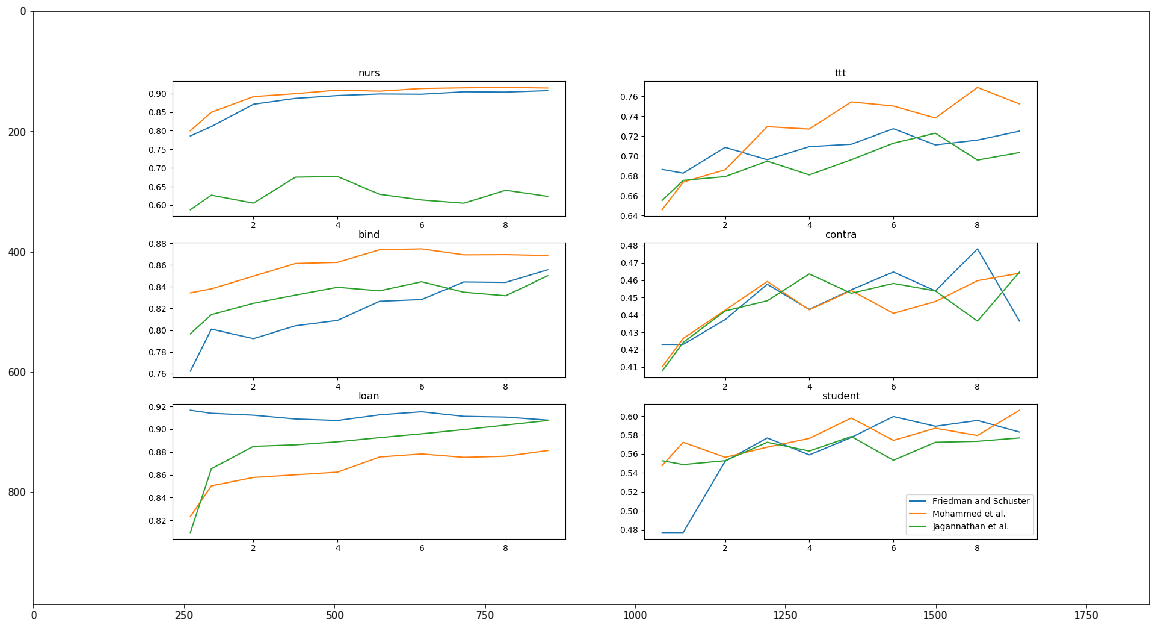

In [16]:
import matplotlib.image
img = matplotlib.image.imread('3Algs6DBs.png')
plt.imshow(img)
plt.show()

How do we explain the graph above? What performance features are in it?  
#### Algorithm Key:  
Friedman and Schuster - Greedy Tree, Stop if size is too small or specified depth is reached (GreedyStop)  
Mohammed et al. - Greedy Tree, Keep going until specified depth is reached (Greedy)  
Jagannathan et al. - Random Tree, Vote with multiple trees (RandomForest)  
#### DB List:
nurs, ttt, bind, contra, loan, student

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)

exec(open('GetGraphs.py').read())
plt.show()

Populating the interactive namespace from numpy and matplotlib


### Idea 1: Impact of Disuniformity.
Define data disuniformity as the Gini coefficient of the sizes of the tree after splitting it along some random attributes. For example, here are the sizes of **nurs** and **loan** split along 4 random attributes:

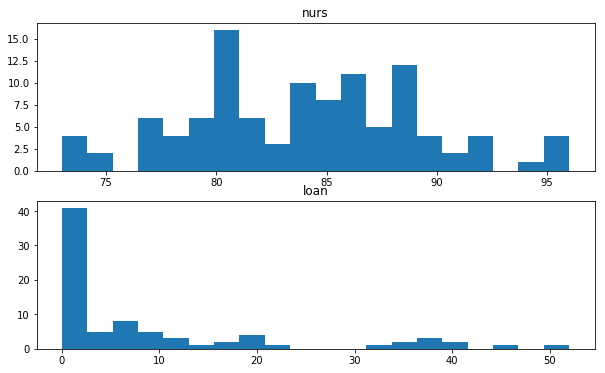

In [40]:
cols_nurs = list(np.random.choice(nurs.x_names, 4, False))
sizes_nurs = np.array(nurs.train.groupby(cols_nurs)[nurs.y_name].count())

cols_loan = list(np.random.choice(loan.x_names, 4, False))
#loan has some empty groups that need to be counted:
possible_attr_count = np.array(list(map(lambda x: len(loan.train[x].unique()), cols_loan))).prod()
sizes_loan = np.array(loan.train.groupby(cols_loan)[loan.y_name].count())
num_zeros = possible_attr_count - len(sizes_loan)
sizes_loan = np.concatenate((sizes_loan, np.repeat(0, num_zeros)))
plt.subplot(211)
plt.title('nurs')
_ = plt.hist(sizes_nurs, bins=20)
plt.subplot(212)
plt.title('loan')
_ = plt.hist(sizes_loan, bins=20)

We can see there is a lot of inequality in **loan** and not in **nurs**. The gini coefficients should reflect that:

In [33]:
print(DTrees.get_gini(sizes_nurs))
print(DTrees.get_gini(sizes_loan))

0.0448992467869
0.546666666667


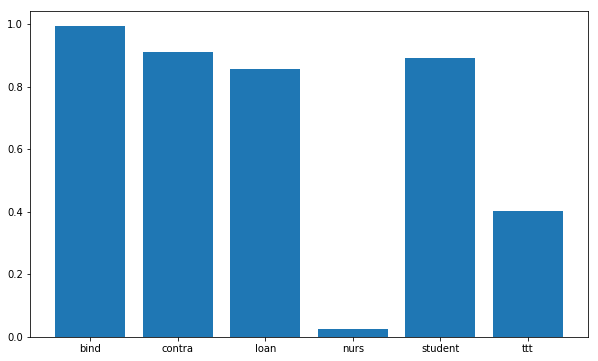

In [39]:
#Gini coefficient of each database
ginis = list(map(lambda x: DTrees.get_size_gini(dblist[x], 0), dblist))
plt.bar(list(dblist.keys()), ginis)
plt.show()

Seeing this, we suspect that GreedyStop will do better at high levels of disuniformity because it will stop when the prediction is likely to be noisy whereas the other two algorithms will do better at lower levels of disuniformity. We plot the number of nodes that were split when a straightforward stop would have been better for the three algos

In [5]:
fs = DTrees.FS(loan, 5, 5)
fs_info = fs.collect_info(loan, 5)
ma = DTrees.MA(loan, 5, 5)
ma_info = ma.collect_info(loan, 5)

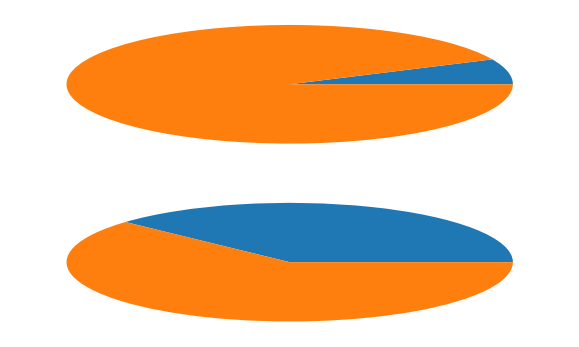

In [11]:
plt.subplot(211)
_ = plt.pie([fs_info[1], fs_info[2] - fs_info[1]])
plt.subplot(212)
_ = plt.pie([ma_info[1], ma_info[2] - ma_info[1]])

In [ ]:
### Idea 2: Impact of 

In [110]:
def get_data(args):
    alg, nm, e, p, i = args
    return alglist[alg](dblist[nm], e, p).get_accuracy()

def execute_product(alglist, dblist, eps_vals, params, reps=10):
    l = []
    for a in alglist:
        for nm in dblist:
            for e in eps_vals:
                for p in params:
                    for i in range(0, reps):
                        l.append((a, nm, e, p, i))
    pool = Pool(processes=10)
    res = pool.map(get_data, l)
    data = pd.DataFrame(l)
    data.columns = ['alg', 'database', 'eps', 'params', 'iter']
    data['perf'] = res
    return data
data = execute_product(alglist, ['nurs'], eps_vals, [1,2,3,4,5], 6)

In [111]:
grps = data.groupby(['alg', 'database', 'eps', 'params'])
dgm = grps.mean()
dgs = grps.agg(np.var)

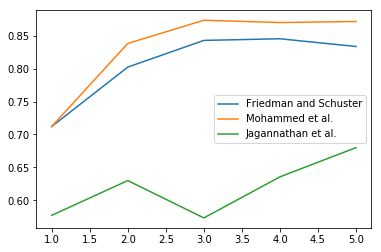

In [123]:
#dgm[dgm.index.get_level_values('params') == 1]
depths = []
for a in alglist:
    depths.append(np.array(dgm['perf'][(dgm.index.get_level_values('alg') == a) &
                                       (dgm.index.get_level_values('eps') == 1)]))
plt.plot([1,2,3,4,5], np.array(depths).T)
plt.legend(list(alglist.keys()))
plt.show()

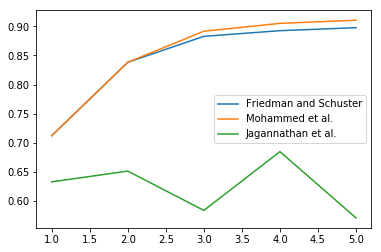

In [124]:
#dgm[dgm.index.get_level_values('params') == 1]
depths = []
for a in alglist:
    depths.append(np.array(dgm['perf'][(dgm.index.get_level_values('alg') == a) &
                                       (dgm.index.get_level_values('eps') == 5)]))
plt.plot([1,2,3,4,5], np.array(depths).T)
plt.legend(list(alglist.keys()))
plt.show()

In [ ]:
#Hypothesis (Still needs testing): The large nodes in nursery benefit much greater from larger depth exploration.
#The low accuracy of Jagannathan is due to the importance of having a feature in the tree (depth 1 shows this fact)
#Furthermore, all the trees trained by Jagannathan are trained to depth 4

In [128]:
k = len(nurs.x_names)
b = sum(map(lambda x: len(np.unique(nurs.train[x])), nurs.x_names))
b = b/k
max_dep = min([np.log(len(nurs.train))/np.log(b)-1, k/2])
max_dep

4.0

In [ ]:
#Why does Mohammed do poorly on loan? It has to be overfitting


In [131]:
def get_data(args):
    alg, nm, e, p, i = args
    return alglist[alg](dblist[nm], e, p).get_accuracy()

def execute_product(alglist, dblist, eps_vals, params, reps=10):
    l = []
    for a in alglist:
        for nm in dblist:
            for e in eps_vals:
                for p in params:
                    for i in range(0, reps):
                        l.append((a, nm, e, p, i))
    pool = Pool(processes=10)
    res = pool.map(get_data, l)
    data = pd.DataFrame(l)
    data.columns = ['alg', 'database', 'eps', 'params', 'iter']
    data['perf'] = res
    return data
data_loan = execute_product(alglist, ['loan'], eps_vals, [1,2,3,4,5], 6)

In [134]:
grps = data_loan.groupby(['alg', 'database', 'eps', 'params'])
dgm = grps.mean()
dgs = grps.agg(np.var)

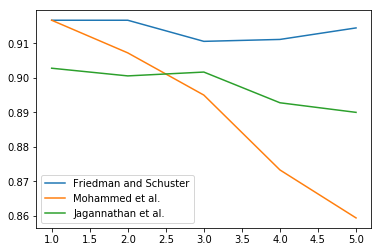

In [139]:
#dgm[dgm.index.get_level_values('params') == 1]
depths = []
for a in alglist:
    depths.append(np.array(dgm['perf'][(dgm.index.get_level_values('alg') == a) &
                                       (dgm.index.get_level_values('eps') == 2)]))
plt.plot([1,2,3,4,5], np.array(depths).T)
plt.legend(list(alglist.keys()))
plt.show()